In [1]:
import numpy as np
import matplotlib.pyplot as plt
import librosa
import librosa.display

import librosa.filters
import math
from scipy import signal
from scipy.io import wavfile

import lws

In [2]:
from os import listdir
from os.path import isfile, join
import ntpath

#wave_dir = '/home/scpark/ai/datasets/LJSpeech-1.1/wavs'
#wave_dir = '/home/scpark/ai/datasets/jeon_re/audio'
wave_dir = '/home/scpark/ai/datasets/dio/audio'
wave_files = [join(wave_dir, f) for f in listdir(wave_dir) if isfile(join(wave_dir, f)) and '.wav' in f]
print(wave_files)

['/home/scpark/ai/datasets/dio/audio/happy_00191.wav', '/home/scpark/ai/datasets/dio/audio/happy_00422.wav', '/home/scpark/ai/datasets/dio/audio/sentence00270.wav', '/home/scpark/ai/datasets/dio/audio/happy_00158.wav', '/home/scpark/ai/datasets/dio/audio/syllable_00005.wav', '/home/scpark/ai/datasets/dio/audio/sentence00184.wav', '/home/scpark/ai/datasets/dio/audio/sentence00072.wav', '/home/scpark/ai/datasets/dio/audio/sentence00232.wav', '/home/scpark/ai/datasets/dio/audio/happy_00286.wav', '/home/scpark/ai/datasets/dio/audio/question_00005.wav', '/home/scpark/ai/datasets/dio/audio/happy_00249.wav', '/home/scpark/ai/datasets/dio/audio/happy_00024.wav', '/home/scpark/ai/datasets/dio/audio/happy_00235.wav', '/home/scpark/ai/datasets/dio/audio/sentence00262.wav', '/home/scpark/ai/datasets/dio/audio/sentence1_00014.wav', '/home/scpark/ai/datasets/dio/audio/sentence4_00013.wav', '/home/scpark/ai/datasets/dio/audio/sentence3_00005.wav', '/home/scpark/ai/datasets/dio/audio/sentence00292.wav

In [3]:
sample_rate = 22050
fft_size = 1024
hop_size = 256
fmin=125
fmax=7600
num_mels=80
min_level_db=-100
ref_level_db=20
allow_clipping_in_normalization=True

def load_wav(path):
    return librosa.core.load(path, sr=sample_rate)[0]

def start_and_end_indices(quantized, silence_threshold=2):
    for start in range(quantized.size):
        if abs(quantized[start] - 127) > silence_threshold:
            break
    for end in range(quantized.size - 1, 1, -1):
        if abs(quantized[end] - 127) > silence_threshold:
            break

    assert abs(quantized[start] - 127) > silence_threshold
    assert abs(quantized[end] - 127) > silence_threshold

    return start, end

def melspectrogram(y):
    D = _lws_processor().stft(y).T
    S = _amp_to_db(_linear_to_mel(np.abs(D))) - ref_level_db
    if not allow_clipping_in_normalization:
        assert S.max() <= 0 and S.min() - min_level_db >= 0
    return _normalize(S)


def get_hop_size():
    return hop_size


def _lws_processor():
    return lws.lws(fft_size, get_hop_size(), mode="speech")


def lws_num_frames(length, fsize, fshift):
    """Compute number of time frames of lws spectrogram
    """
    pad = (fsize - fshift)
    if length % fshift == 0:
        M = (length + pad * 2 - fsize) // fshift + 1
    else:
        M = (length + pad * 2 - fsize) // fshift + 2
    return M


def lws_pad_lr(x, fsize, fshift):
    """Compute left and right padding lws internally uses
    """
    M = lws_num_frames(len(x), fsize, fshift)
    pad = (fsize - fshift)
    T = len(x) + 2 * pad
    r = (M - 1) * fshift + fsize - T
    return pad, pad + r

# Conversions:


_mel_basis = None


def _linear_to_mel(spectrogram):
    global _mel_basis
    if _mel_basis is None:
        _mel_basis = _build_mel_basis()
    return np.dot(_mel_basis, spectrogram)


def _build_mel_basis():
    assert fmax <= sample_rate // 2
    return librosa.filters.mel(sample_rate, fft_size,
                               fmin=fmin, fmax=fmax,
                               n_mels=num_mels)


def _amp_to_db(x):
    min_level = np.exp(min_level_db / 20 * np.log(10))
    return 20 * np.log10(np.maximum(min_level, x))


def _db_to_amp(x):
    return np.power(10.0, x * 0.05)


def _normalize(S):
    return np.clip((S - min_level_db) / -min_level_db, 0, 1)


def _denormalize(S):
    return (np.clip(S, 0, 1) * -min_level_db) + min_level_db


In [4]:
def load_wave_and_mel(wav_path):
    wav = load_wav(wav_path)
    wav = wav / np.abs(wav).max()
    
    # [-1, 1]
    out = wav
    constant_values = 0.0
    out_dtype = np.float32
    
    # Compute a mel-scale spectrogram from the trimmed wav:
    # (N, D)
    mel_spectrogram = melspectrogram(wav).astype(np.float32).T
    # lws pads zeros internally before performing stft
    # this is needed to adjust time resolution between audio and mel-spectrogram
    l, r = lws_pad_lr(wav, fft_size, get_hop_size())

    # zero pad for quantized signal
    out = np.pad(out, (l, r), mode="constant", constant_values=constant_values)
    N = mel_spectrogram.shape[0]
    assert len(out) >= N * get_hop_size()

    # time resolution adjustment
    # ensure length of raw audio is multiple of hop_size so that we can use
    # transposed convolution to upsample
    out = out[:N * get_hop_size()]
    assert len(out) % get_hop_size() == 0

    return out, mel_spectrogram

(67072,) (262, 80)


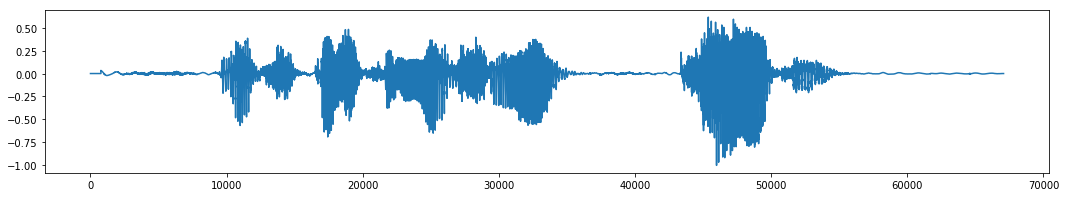

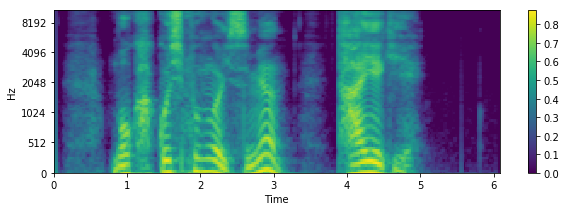

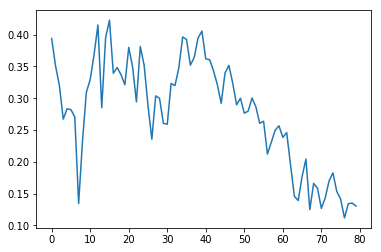

In [12]:
wave, mel = load_wave_and_mel(wave_files[0])
print(wave.shape, mel.shape)

plt.figure(figsize=[18, 3])
plt.plot(wave)
plt.show()

plt.figure(figsize=[10, 3])
librosa.display.specshow(mel.T, cmap='viridis', y_axis='mel', fmax=int(sample_rate / 2), x_axis='time')
plt.colorbar()
plt.show()

plt.plot(mel[20])
plt.show()

import IPython.display as ipd
ipd.Audio(wave, rate=sample_rate)

In [ ]:
from tqdm import tqdm
import threading

def work(wave_file, save_dir):
    wave, mel = load_wave_and_mel(wave_file)
    
    data = {'wave':wave, 'mel': mel}
    filename = save_dir + '/' + ntpath.basename(wave_file)[:-4]
    np.savez(filename, **data, allow_pickle=False)

save_dir = '/home/scpark/ai/datasets/waveglow-datasets/dio'
threads = []
for wave_file in tqdm(wave_files):

    thread = threading.Thread(target=work, args=(wave_file, save_dir))
    threads.append(thread)

    if len(threads) > 16:
        for thread in threads:
            thread.start()

        for thread in threads:
            thread.join()

        threads = []


